# Modeling

In [1]:
# !pip install s2sphere
# !pip install mapsplotlib

In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
import s2sphere
import matplotlib.pyplot as plt

## Connect

In [2]:
conf = SparkConf().setAppName("msds697_project")
sc = SparkContext(conf=conf)
sc.setLogLevel("OFF")

In [3]:
ss = SparkSession.builder.getOrCreate()

## Join SF and NYC Data

In [21]:
nyc_sf_df.rdd.saveAsPickleFile("./data/nyc_sf_rdd_cleaned.pkl")

In [22]:
nyc_sf_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- cell_id: string (nullable = true)
 |-- city: string (nullable = false)



In [91]:
nyc_sf_df = ss.createDataFrame(sc.pickleFile("./data/nyc_sf_rdd_cleaned.pkl").collect())

In [84]:
nyc_sf_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- cell_id: string (nullable = true)
 |-- city: string (nullable = true)



In [85]:
nyc_sf_df.count()

281

## Run clustering

In [28]:
from pyspark.ml.clustering import KMeans
from tqdm import tqdm

In [29]:
print("ok")

ok


In [87]:
%%time 
#n_clusters = 300

#n_clusters_list = (300, 500, 1000, 1500, 2000, 5000)
n_clusters_list = range(5, 50, 5)

scores = []
for n_clusters in tqdm(n_clusters_list):
    kmeans = KMeans(k=n_clusters)
    kmeans_model = kmeans.fit(nyc_sf_df.select("scaledFeatures").withColumnRenamed("scaledFeatures", "features"))
    score = kmeans_model.computeCost(nyc_sf_df)
    print(n_clusters, score)
    scores.append(score)

 11%|█         | 1/9 [00:00<00:04,  1.67it/s]

5 1437320724567.1108


 22%|██▏       | 2/9 [00:01<00:04,  1.60it/s]

10 1437320720373.346


 33%|███▎      | 3/9 [00:01<00:03,  1.68it/s]

15 1437320719597.4236


 44%|████▍     | 4/9 [00:02<00:02,  1.70it/s]

20 1437320719592.9082


 56%|█████▌    | 5/9 [00:02<00:02,  1.73it/s]

25 1437320719155.2378


 67%|██████▋   | 6/9 [00:03<00:01,  1.58it/s]

30 1437320716207.3108


 78%|███████▊  | 7/9 [00:04<00:01,  1.62it/s]

35 1437320717045.8574


 89%|████████▉ | 8/9 [00:04<00:00,  1.70it/s]

40 1437320716251.4365


100%|██████████| 9/9 [00:05<00:00,  1.79it/s]

45 1437320716164.4592
CPU times: user 161 ms, sys: 73.1 ms, total: 235 ms
Wall time: 5.29 s


In [88]:
scores = np.array(scores)
scores

array([1.43732072e+12, 1.43732072e+12, 1.43732072e+12, 1.43732072e+12,
       1.43732072e+12, 1.43732072e+12, 1.43732072e+12, 1.43732072e+12,
       1.43732072e+12])

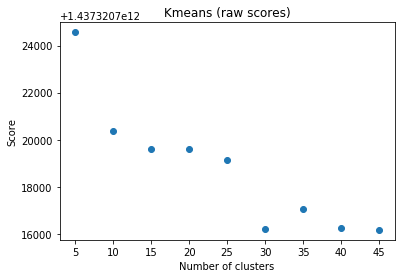

In [89]:
plt.scatter(n_clusters_list, scores)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Kmeans (raw scores)")
plt.show()

/home/julia/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


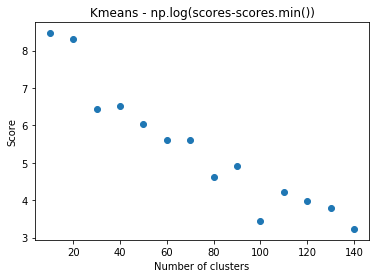

In [44]:
plt.scatter(n_clusters_list,  np.log(scores-scores.min()))
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Kmeans - np.log(scores-scores.min())")
plt.show()

In [ ]:
from pyspark.ml.clustering import BisectingKMeans
n_clusters_list = (100, 300, 500, 700, 900, 1100, 2000, 3000)


bscores = []
for n_clusters in tqdm(n_clusters_list):
    bkmeans = BisectingKMeans(k=n_clusters)
    bkmeans_model = bkmeans.fit(nyc_sf_df.select("scaledFeatures").withColumnRenamed("scaledFeatures", "features"))
    score = bkmeans_model.computeCost(nyc_sf_df)
    print(n_clusters, scores)

    bscores.append(score)

In [ ]:
plt.scatter(n_clusters_list, scores)
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.title("Bisecting Kmeans")
plt.show()

In [45]:
nyc_sf_df.count()

281

In [119]:
nyc_sf_df = nyc_sf_df.drop("prediction")

In [120]:
%%time 
n_clusters = 15
kmeans = KMeans(k=n_clusters)
kmeans_model = kmeans.fit(nyc_sf_df.select("scaledFeatures").withColumnRenamed("scaledFeatures", "features"))
nyc_sf_df = kmeans_model.transform(nyc_sf_df)

CPU times: user 12.2 ms, sys: 12.2 ms, total: 24.4 ms
Wall time: 530 ms


In [9]:
# score = kmeans_model.computeCost(nyc_sf_df)
# print("Within Set Sum of Squared Errors = " + str(score))

## Evaluation

### What are some examples of areas in the same cluster?

In [93]:
def vector_distance_fun(x, cluster_centers = kmeans_model.clusterCenters()):
    features, centroid = x
    centroid = cluster_centers[centroid]
    import math
    return math.sqrt(features.squared_distance(centroid))

In [108]:
vector_distance = udf(lambda x: vector_distance_fun(x), DoubleType())

In [121]:
%%time
distances_df = nyc_sf_df.withColumn("distance_from_centroid", vector_distance(struct("scaledFeatures", "prediction")))
distances_df.count()

CPU times: user 5.05 ms, sys: 0 ns, total: 5.05 ms
Wall time: 82.9 ms


In [110]:
distances_df.show(10)

+--------------------+--------------------+--------+----+----------+----------------------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|
+--------------------+--------------------+--------+----+----------+----------------------+
|[500.0,500.0,613....|[0.56797932942684...|808580cc|  SF|         1|     35.60300858251154|
|(116,[0,1,2,3,4,5...|(116,[0,1,2,3,4,5...|89c2f694|  NY|         7|     18.97774076441892|
|[151.0,103.0,116....|[0.17152975748690...|808f7e5c|  SF|         1|     41.70292956577847|
|[8.0,15.0,13.0,15...|[0.00908766927082...|808f7d74|  SF|        12|     45.44130191245168|
|[152.0,113.0,148....|[0.17266571614576...|808f7fcc|  SF|         1|     41.49615836155718|
|[8435.0,9768.0,90...|[0.47149994407691...|89c258b4|  NY|         1|     38.59192131302387|
|[25.0,49.0,25.0,6...|[0.00139745093087...|89c2f634|  NY|         1|    43.718499347922545|
|[106.0,95.0,92.0,...|[0.00592519194690...|89c2f68c|  NY|         1|     43.6900

In [122]:
from pyspark.sql.window import Window

w = Window.partitionBy(["prediction", "city"]).orderBy("distance_from_centroid")

distances_df = distances_df.withColumn('row_id', monotonically_increasing_id())

closest_distances_df = distances_df.withColumn("dist_id", 
                        first(distances_df.row_id).over(w)
                       ).filter("row_id = dist_id").\
select("city", "cell_id", "prediction", "distance_from_centroid")

closest_distances_df.orderBy("distance_from_centroid").show(3)

+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c25ebc|         0|   0.47517590853498726|
|  SF|808f7c4c|         4|    0.5277094626950019|
|  NY|89c2f414|         4|    1.5878944086003217|
+----+--------+----------+----------------------+
only showing top 3 rows



In [112]:
closest_distances_df.orderBy("distance_from_centroid", ascending=False).show(3)

+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c2f654|         5|     79.70583186326913|
|  SF|808f7edc|         5|     79.53034692804368|
|  NY|89c25874|        12|    45.380220370948244|
+----+--------+----------+----------------------+
only showing top 3 rows



In [92]:
# best_cluster = closest_distances_df.orderBy("distance_from_centroid").first().prediction

In [113]:
tmp_df = closest_distances_df.groupBy("prediction")\
.agg(count("cell_id").alias("n"), avg("distance_from_centroid").alias("avg_distance"))
print(tmp_df.printSchema)
best_clusters = tmp_df.filter(tmp_df.n>1)\
.orderBy("avg_distance").select('prediction').take(30)
#.agg(avg("distance_from_centroid").alias("avg_distance"))


<bound method DataFrame.printSchema of DataFrame[prediction: int, n: bigint, avg_distance: double]>


In [54]:
best_clusters[0].prediction

27

['89c258fc', '8085808c']

1
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c259ac|         1|     5.308291269210847|
|  SF|80858084|         1|    15.804101331011587|
+----+--------+----------+----------------------+



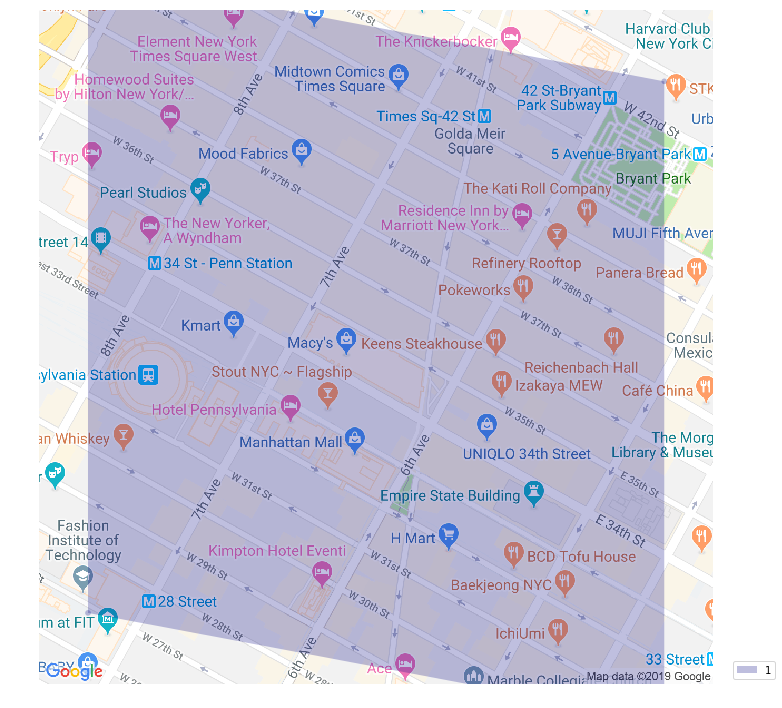

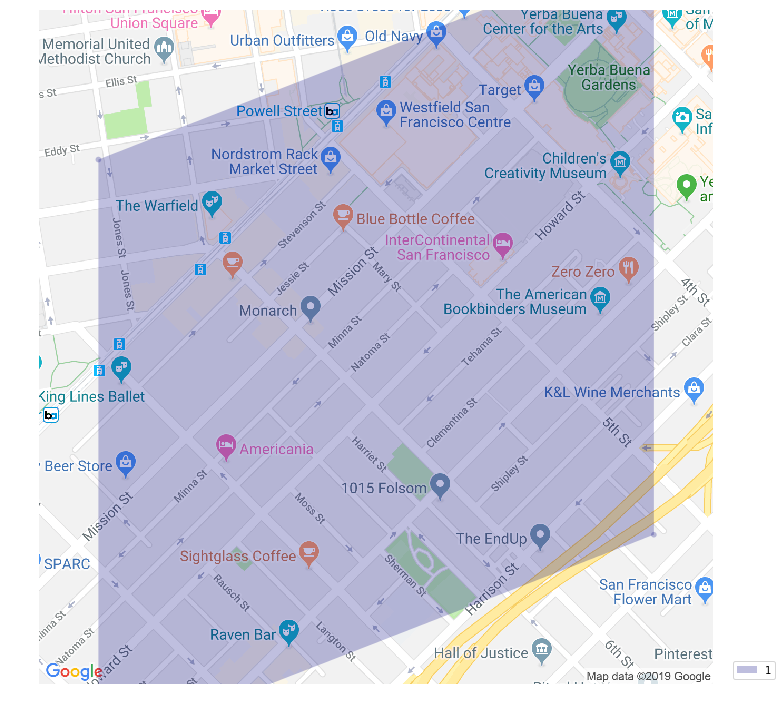

2
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|80858014|         2|    15.374492287034279|
|  NY|89c2f154|         2|    15.422089678970408|
+----+--------+----------+----------------------+



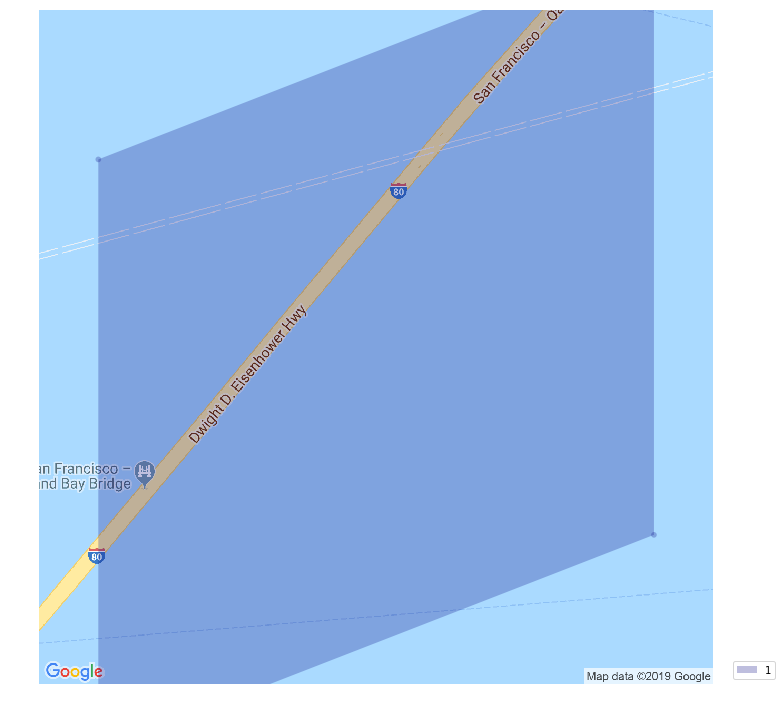

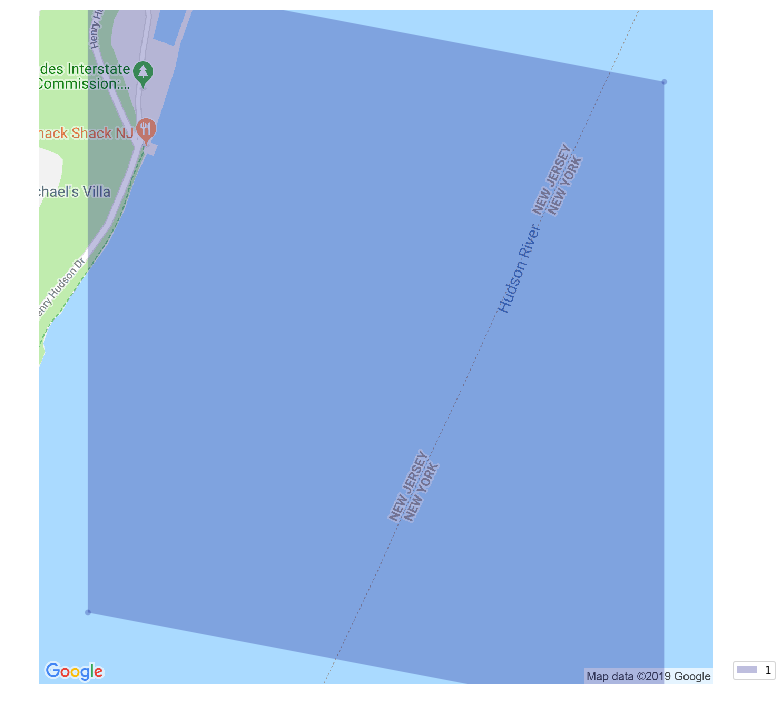

3
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|808586e4|         3|     36.96181736287343|
|  NY|89c2f7dc|         3|    37.129858107794846|
+----+--------+----------+----------------------+



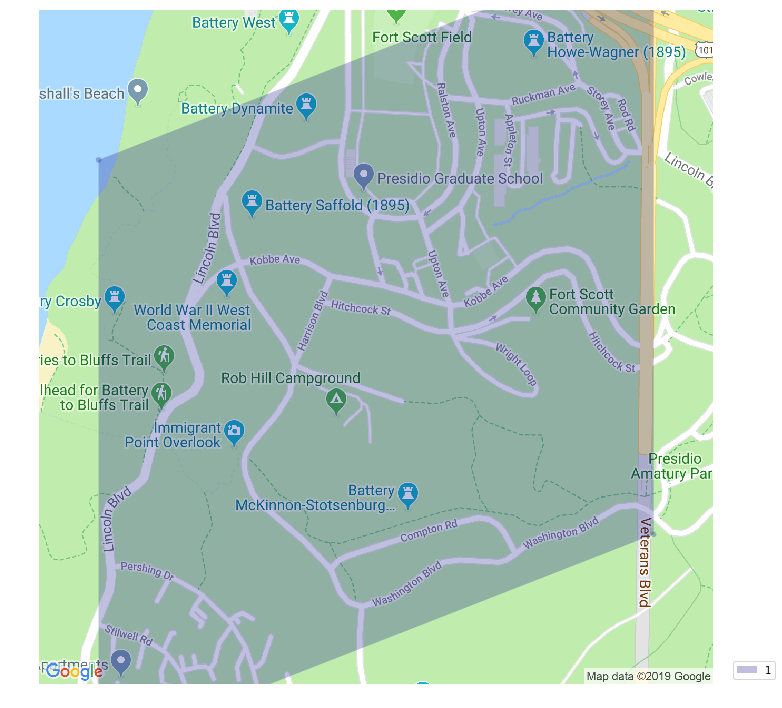

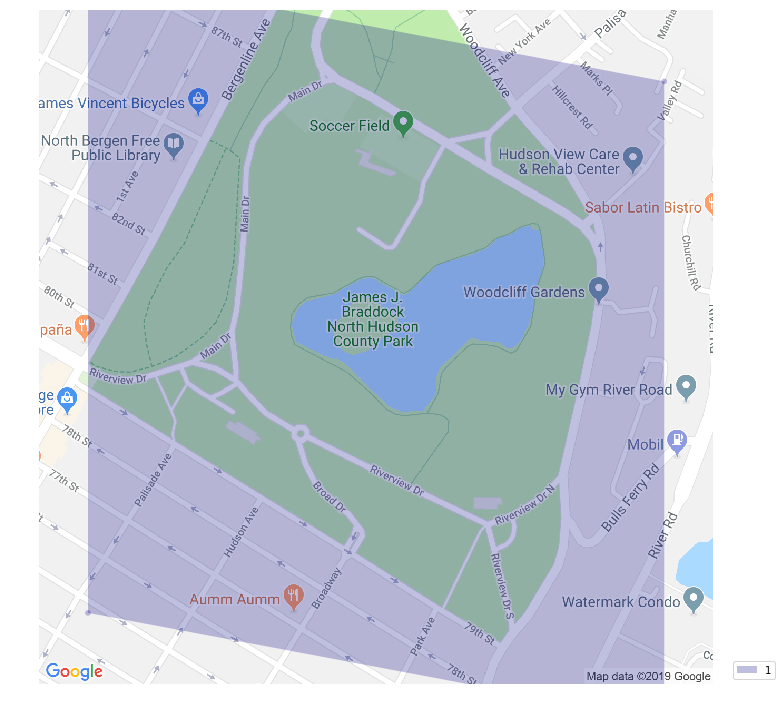

4
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|808f7c4c|         4|    0.5277094626950019|
|  NY|89c2f414|         4|    1.5878944086003217|
+----+--------+----------+----------------------+



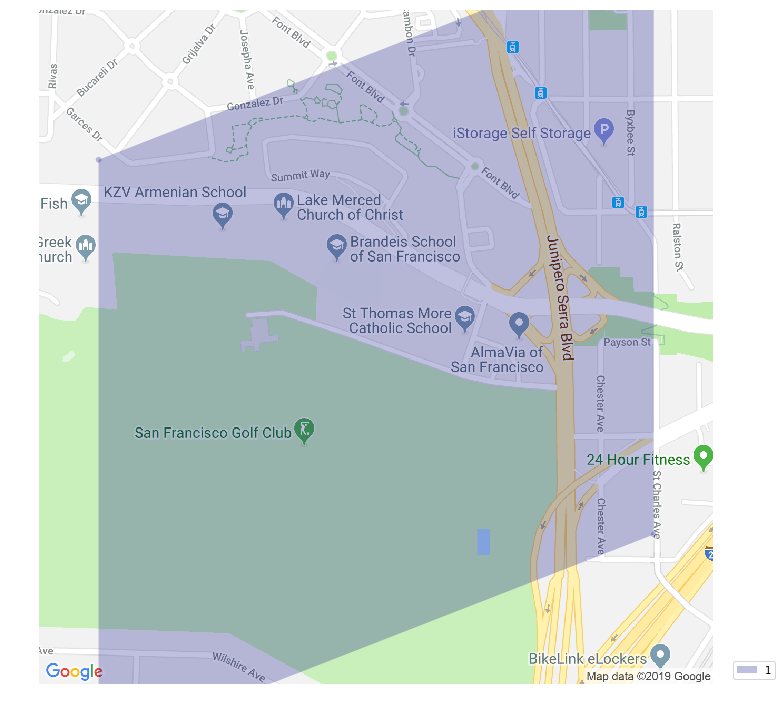

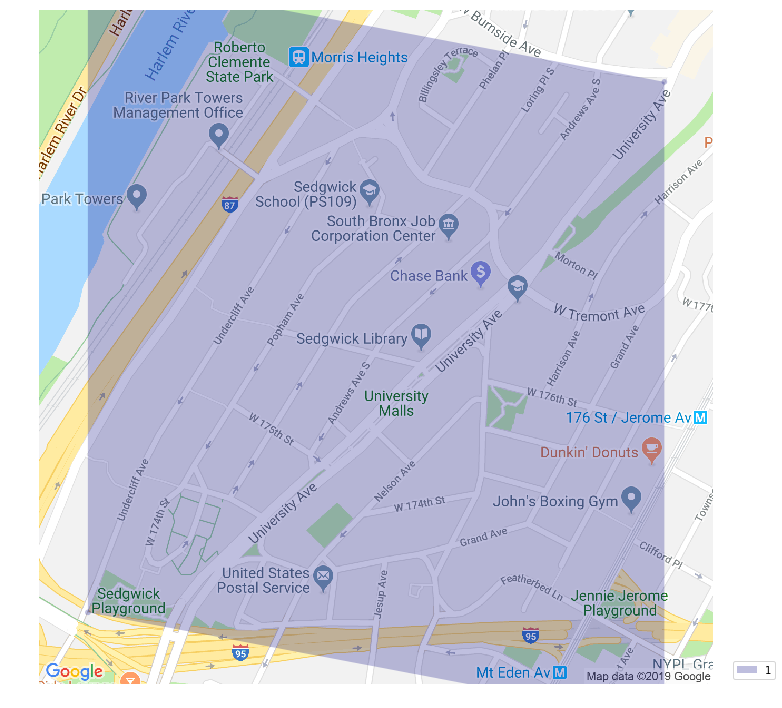

5
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c2f654|         5|     79.70583186326913|
|  SF|808f7edc|         5|     79.53034692804368|
+----+--------+----------+----------------------+



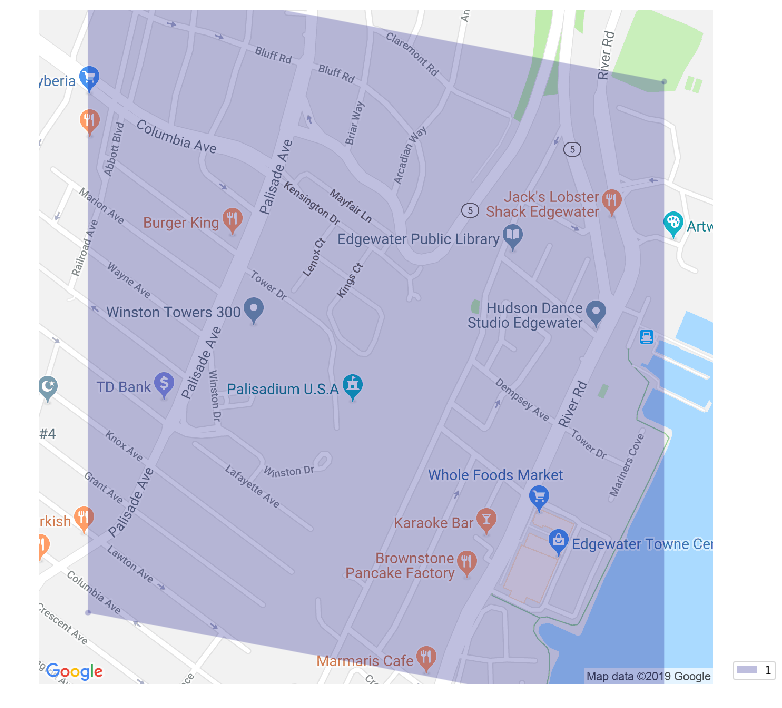

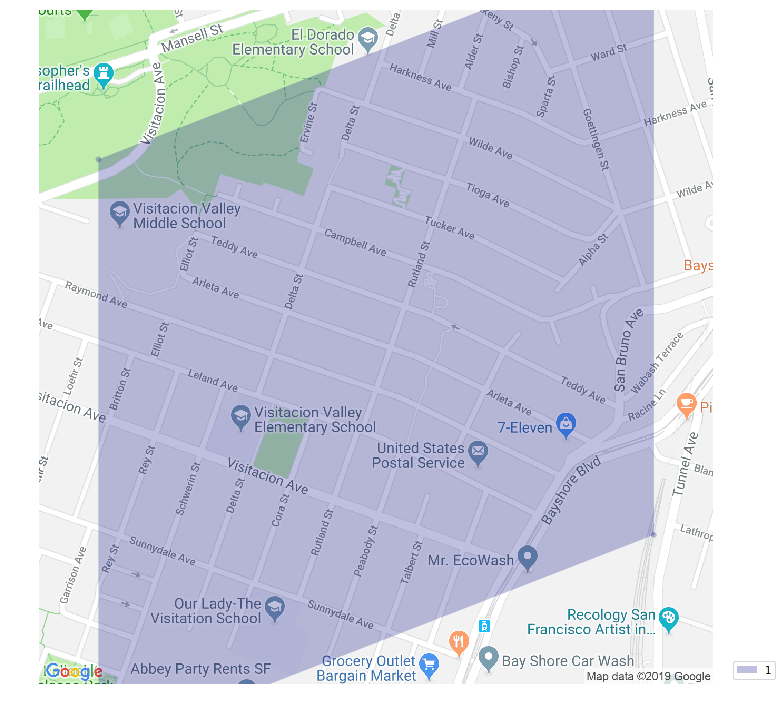

6
+----+-------+----------+----------------------+
|city|cell_id|prediction|distance_from_centroid|
+----+-------+----------+----------------------+
+----+-------+----------+----------------------+

7
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c2f7c4|         7|    18.780358951075396|
|  SF|808f7f3c|         7|     18.85925439198824|
+----+--------+----------+----------------------+



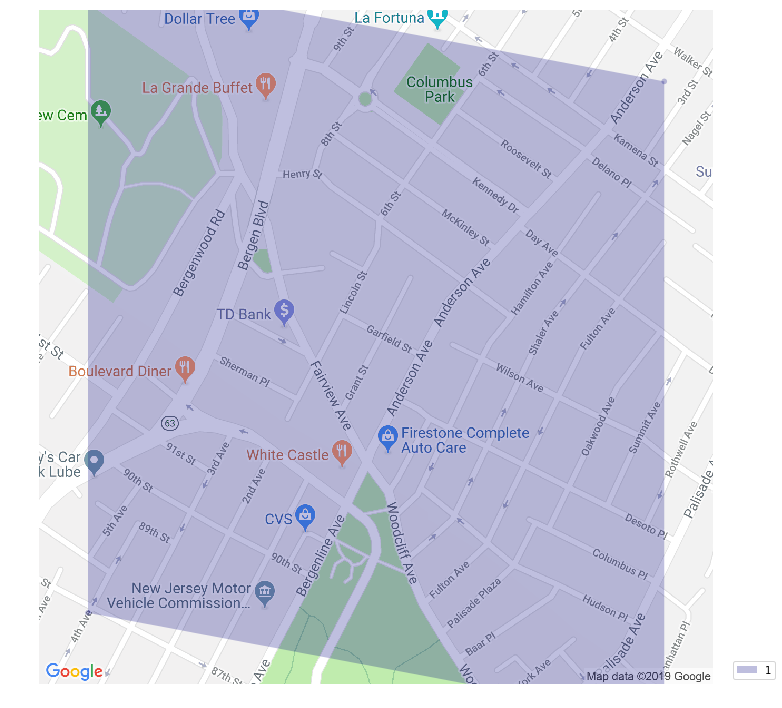

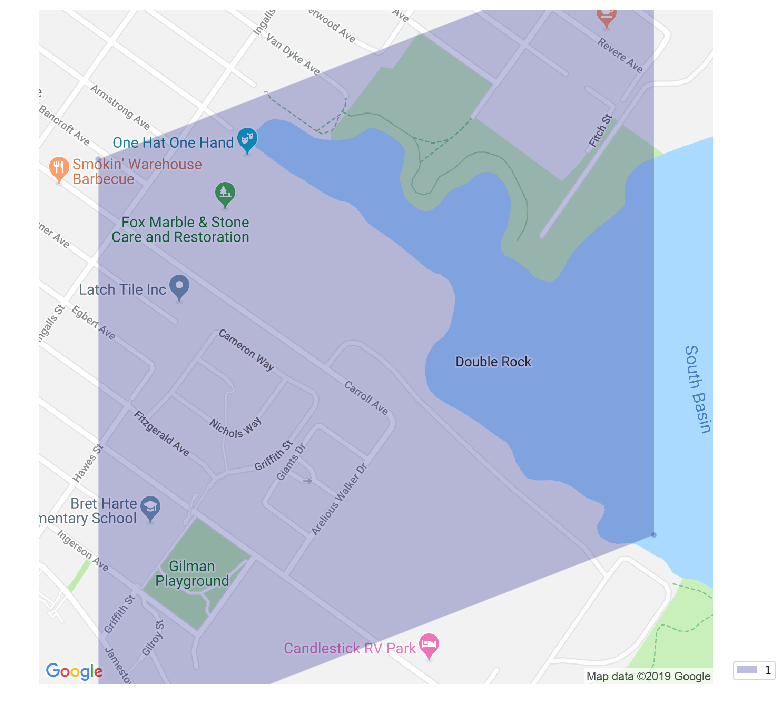

8
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c2f73c|         8|     5.825172015741311|
|  SF|80858044|         8|     4.793338784578446|
+----+--------+----------+----------------------+



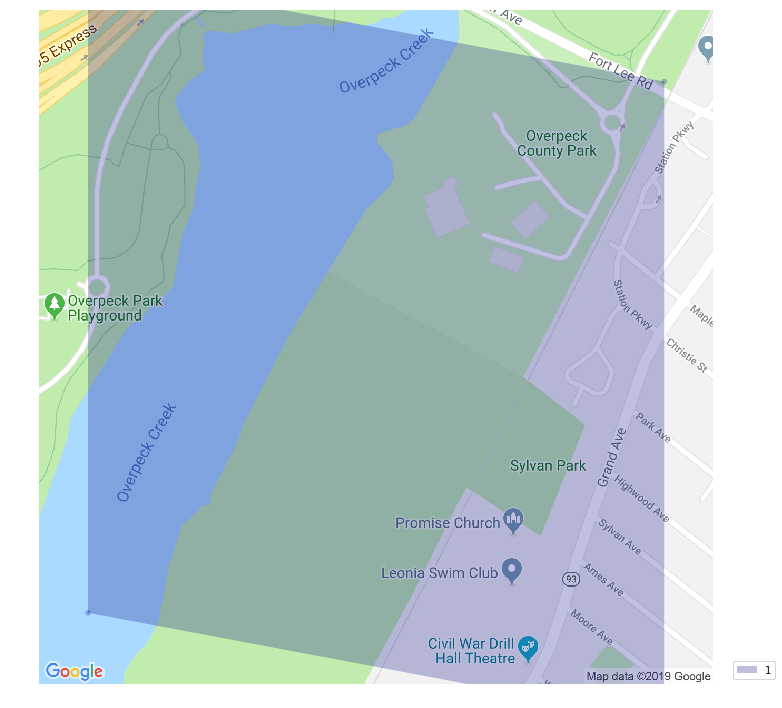

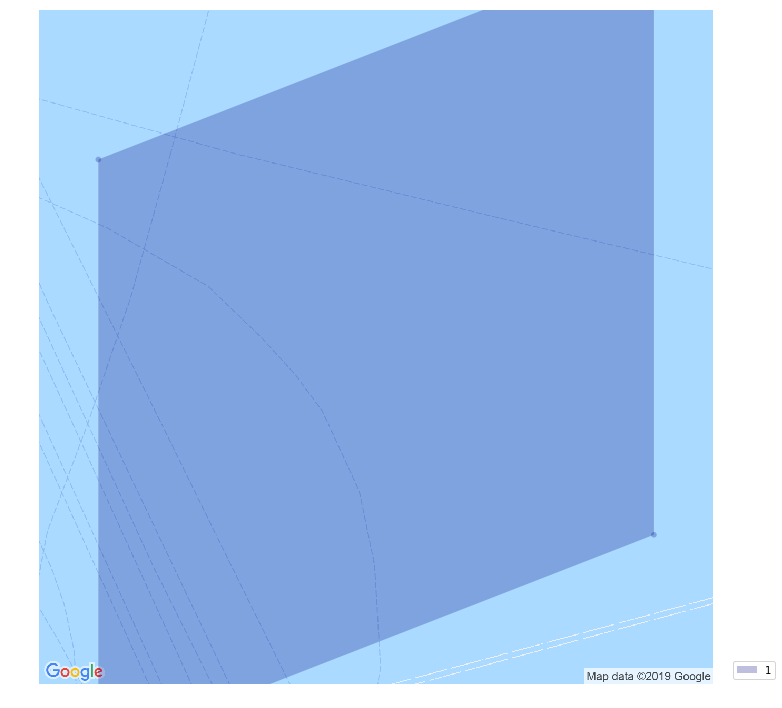

9
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|808586c4|         9|    11.478820557471455|
+----+--------+----------+----------------------+



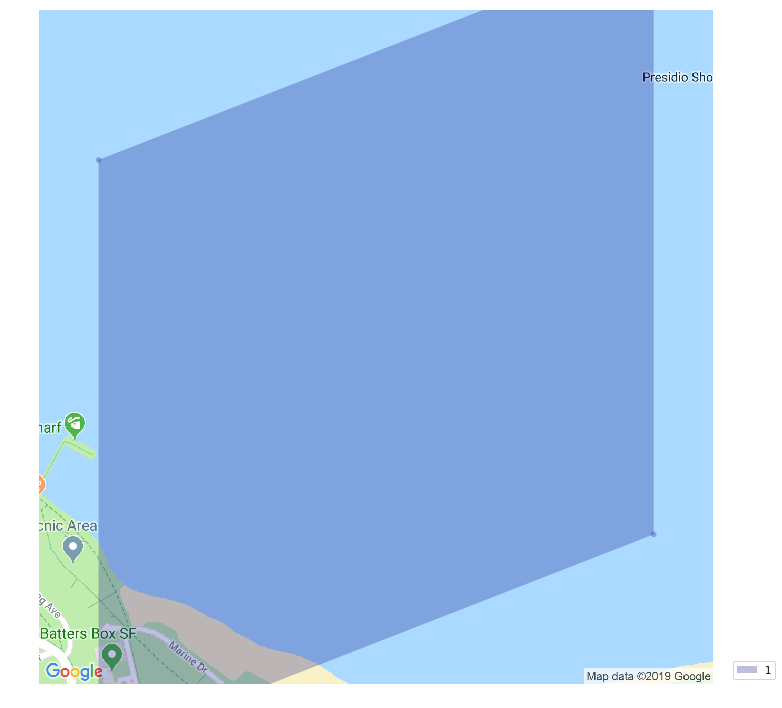

10
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|8085806c|        10|    29.485310355616356|
|  NY|89c2f704|        10|    29.635959171941355|
+----+--------+----------+----------------------+



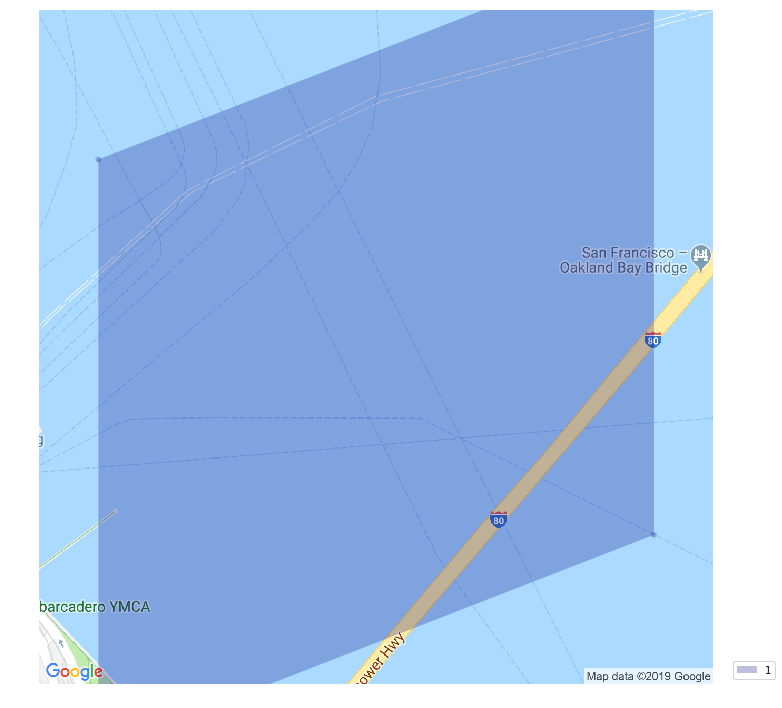

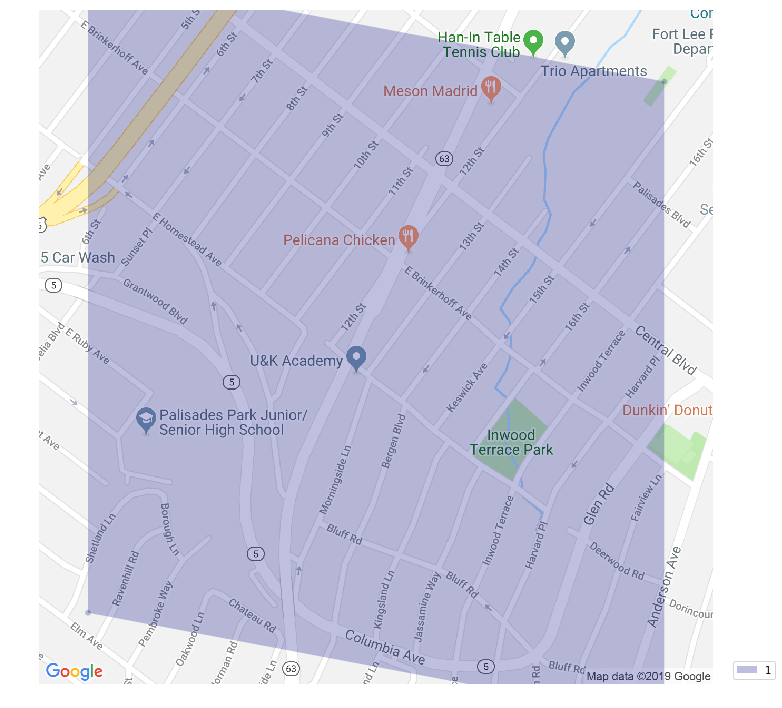

11
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|808f7d64|        11|    27.510746424705886|
+----+--------+----------+----------------------+



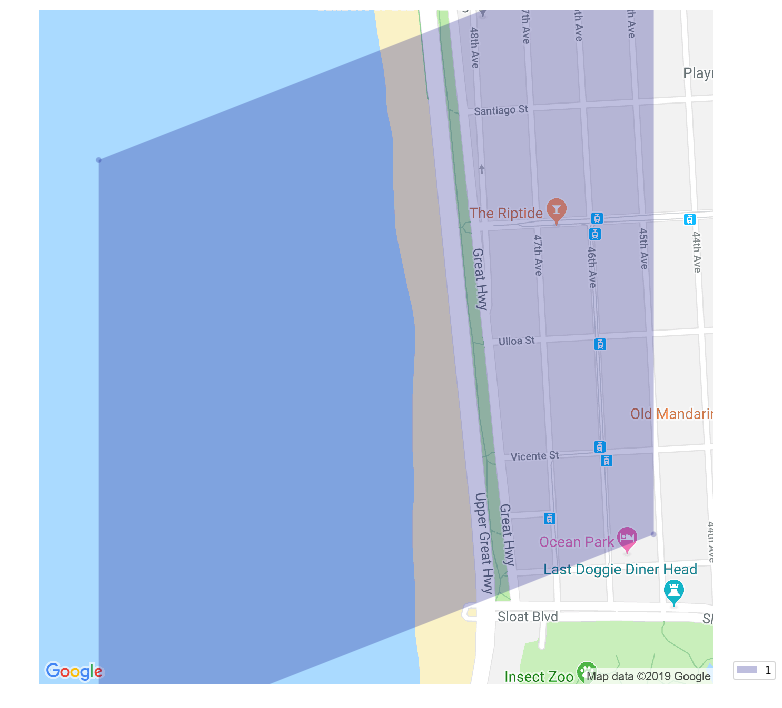

12
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|808f7fa4|        12|    45.117296087402146|
|  NY|89c25874|        12|    45.380220370948244|
+----+--------+----------+----------------------+



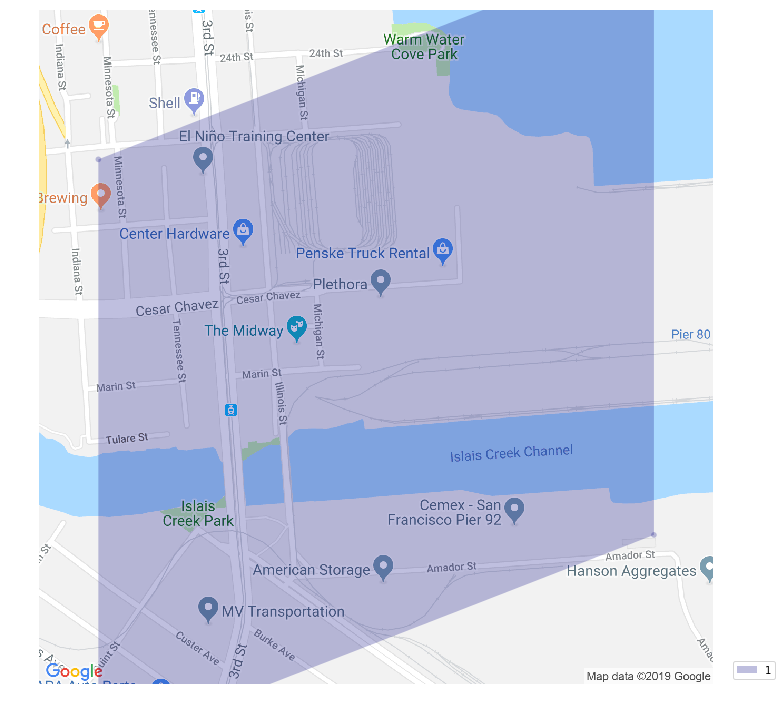

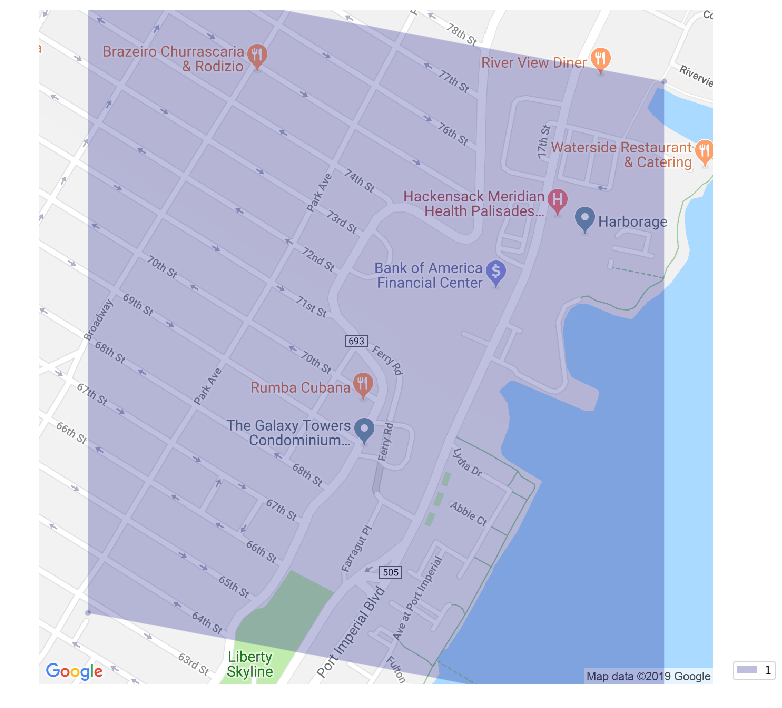

13
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|89c2f6e4|        13|    20.396496459965835|
+----+--------+----------+----------------------+



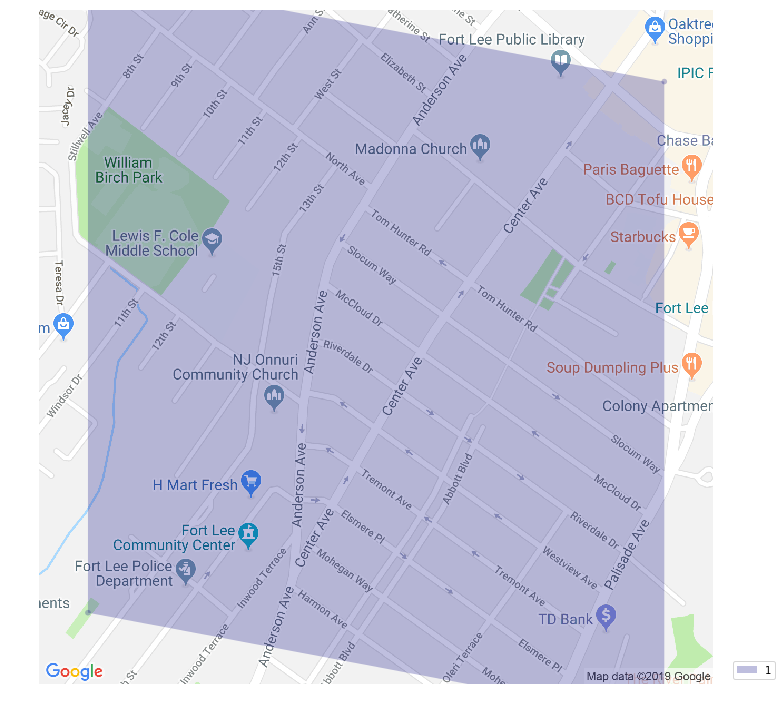

14
+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  SF|808f7f74|        14|    31.094330051800032|
+----+--------+----------+----------------------+



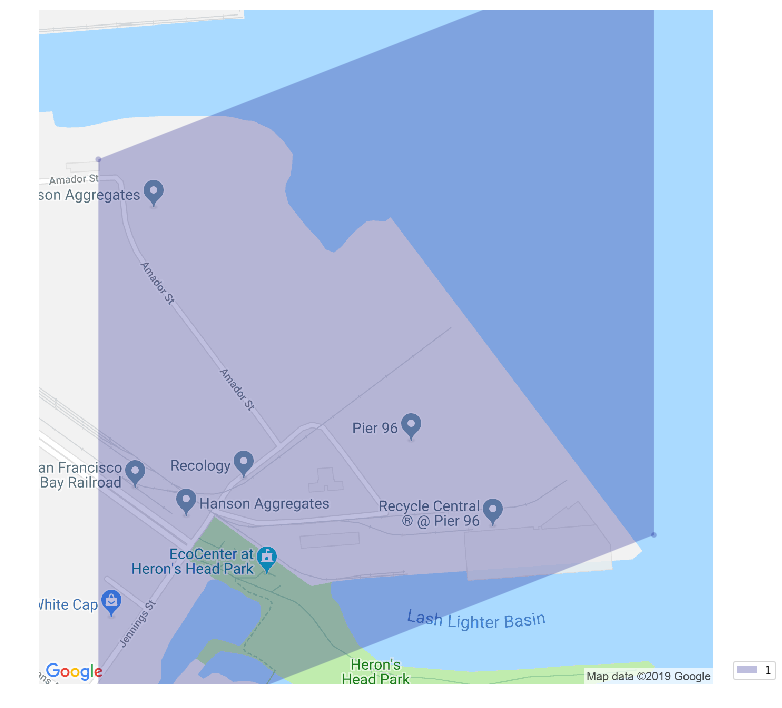

15
+----+-------+----------+----------------------+
|city|cell_id|prediction|distance_from_centroid|
+----+-------+----------+----------------------+
+----+-------+----------+----------------------+



In [123]:
#for best_cluster in best_clusters:
#    best_cluster = best_cluster.prediction
for best_cluster in range(1, n_clusters+1):
    print(best_cluster)
    tmp_df = closest_distances_df\
.filter(closest_distances_df.prediction == best_cluster)
    tmp_df.show()
    if tmp_df.count() == 2:
    #try:
        cell_a, cell_b = [row.cell_id for row in closest_distances_df\
    .filter(closest_distances_df.prediction == best_cluster).take(2)]
        show_cell(cell_a)
        show_cell(cell_b)
    elif tmp_df.count() == 1:
    #except:
        cell_a = [row.cell_id for row in closest_distances_df\
    .filter(closest_distances_df.prediction == best_cluster).take(1)]
        show_cell(cell_a[0])
    elif tmp_df.count() > 0:
        print("count: ", tmp_df.count())

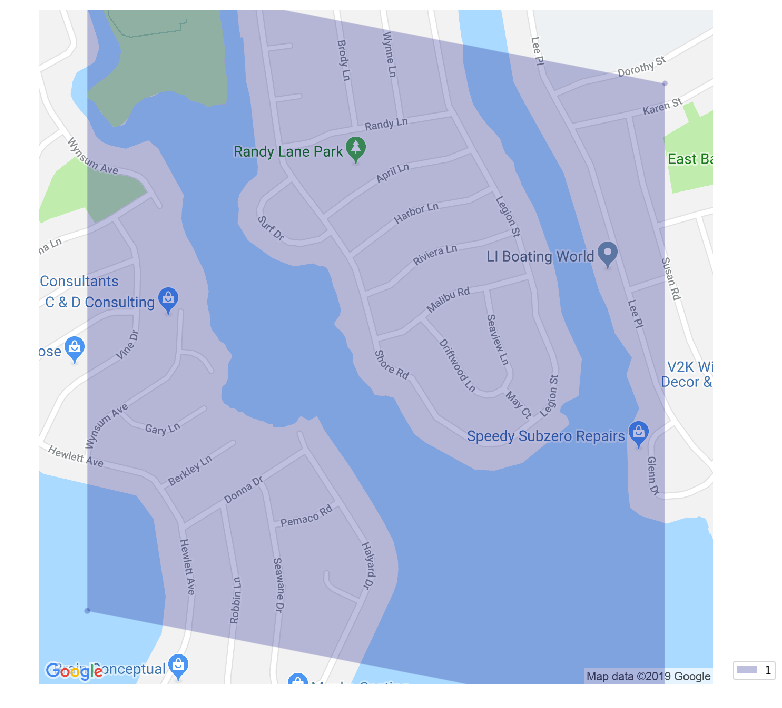

In [27]:
show_cell("89c27934")

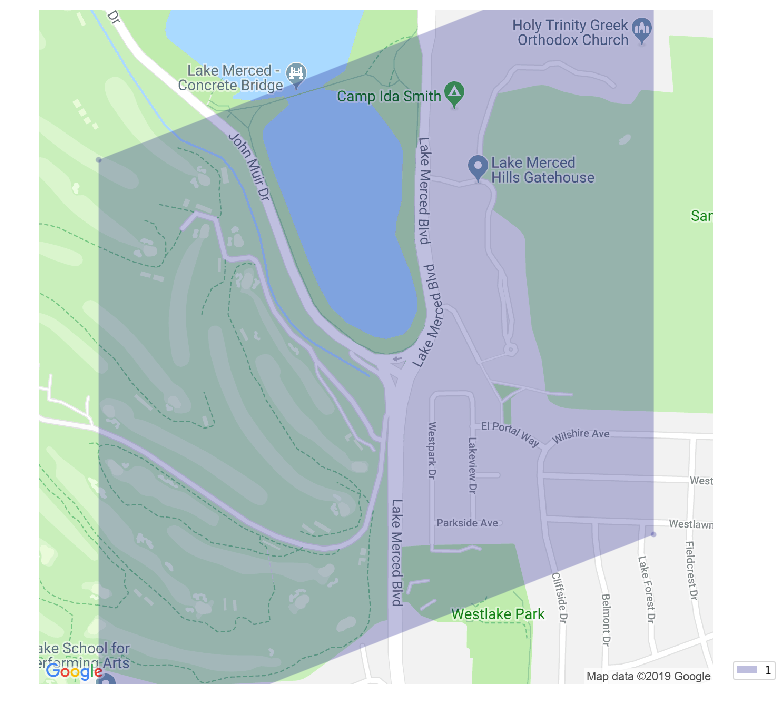

In [28]:
show_cell("808f7c54")

In [103]:
closest_distances_df.orderBy("distance_from_centroid")\
.filter(closest_distances_df.prediction == best_cluster).show()

+----+--------+----------+----------------------+
|city| cell_id|prediction|distance_from_centroid|
+----+--------+----------+----------------------+
|  NY|6aab478c|       111|                   0.0|
+----+--------+----------+----------------------+



In [69]:
rows = closest_distances_df.filter(closest_distances_df.prediction == best_cluster).select("cell_id").take(2)

In [68]:
rows

[Row(cell_id='89e828f4')]

In [67]:
cell_1, cell_2 = [r.cell_id for r in rows]
cell_1, cell_2

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
show_cell(cell_1)

In [ ]:
show_cell(cell_2)

### What part of SF is most similar to Times Square?

In [39]:
nyc_popular_cell_id = "89c258fc"
distances_df.filter(distances_df.cell_id == nyc_popular_cell_id).show()

+--------------------+--------------------+--------+----+----------+----------------------+-----------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|     row_id|
+--------------------+--------------------+--------+----+----------+----------------------+-----------+
|[120801.0,144700....|[32.2497080603825...|89c258fc|  NY|       114|                   0.0|42949673632|
+--------------------+--------------------+--------+----+----------+----------------------+-----------+



In [40]:
pred_number = distances_df.filter(distances_df.cell_id == nyc_popular_cell_id).first().prediction

In [42]:
tmp_df = distances_df.filter((distances_df.prediction == pred_number) & (distances_df.city == "SF"))\
.orderBy("distance_from_centroid")
tmp_df.show(5)
closest_to_times = tmp_df.take(5)

+--------------------+--------------------+--------+----+----------+----------------------+-----------+
|            features|      scaledFeatures| cell_id|city|prediction|distance_from_centroid|     row_id|
+--------------------+--------------------+--------+----+----------+----------------------+-----------+
|[7303.0,7032.0,74...|[8.29590608560852...|8085808c|  SF|       114|    214.48806853164658| 8589934999|
|[3994.0,4748.0,47...|[4.53701888346165...|80858064|  SF|       114|    250.14627295631578| 8589934810|
|[3219.0,2935.0,29...|[3.65665092285003...|80858094|  SF|       114|    255.30319564591017|         64|
|[2973.0,2318.0,23...|[3.37720509277203...|80858084|  SF|       114|    260.61311512455393|34359738416|
|[2149.0,1905.0,19...|[2.44117515787658...|808580f4|  SF|       114|     266.6263860257717|60129542405|
+--------------------+--------------------+--------+----+----------+----------------------+-----------+
only showing top 5 rows



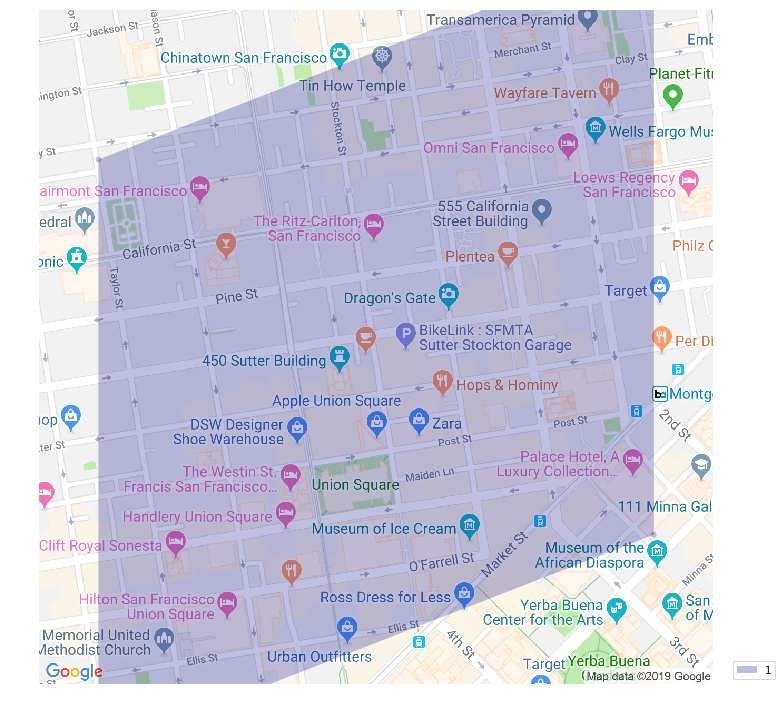

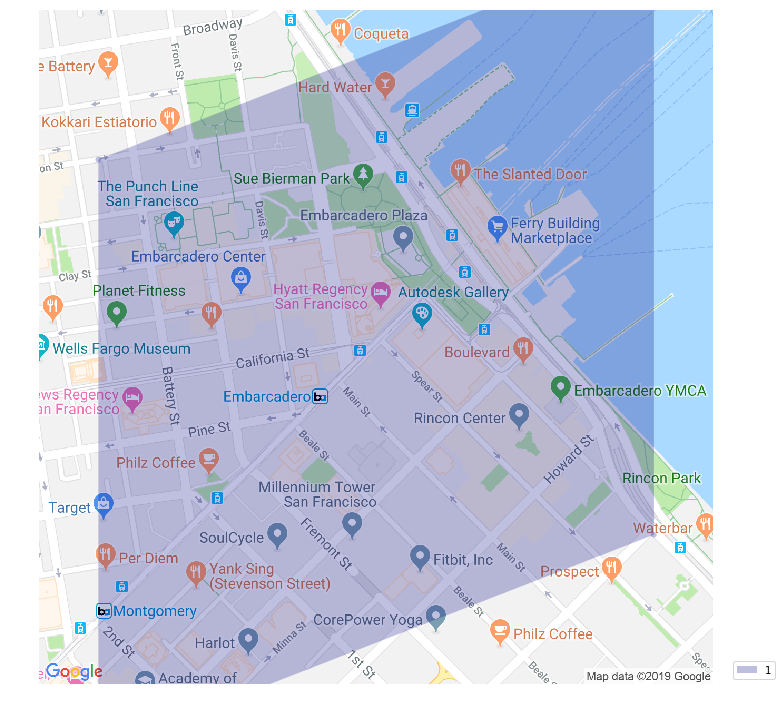

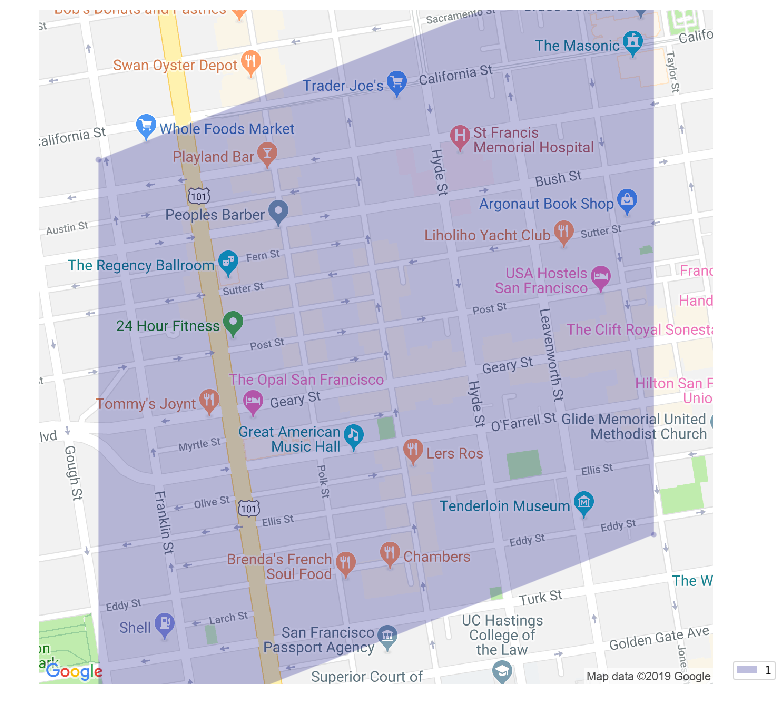

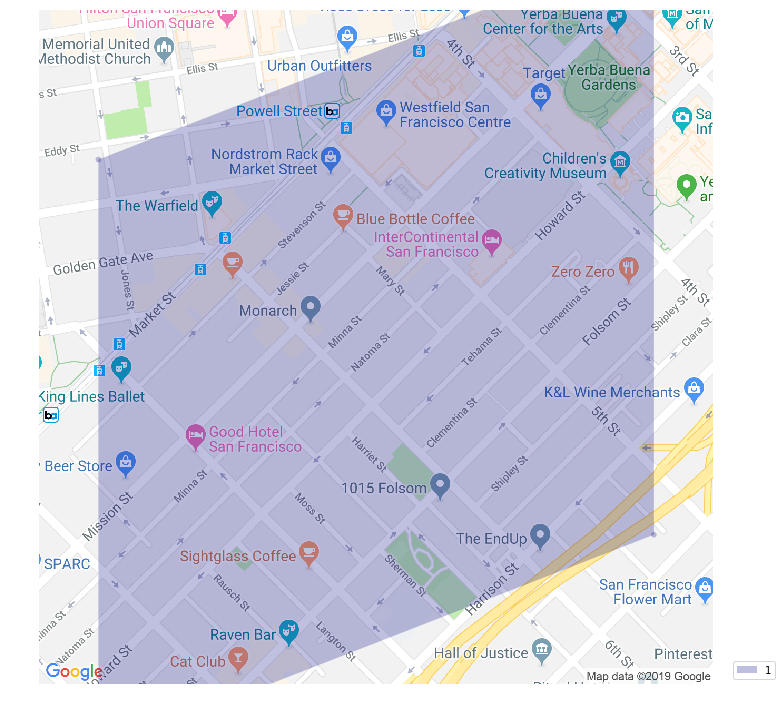

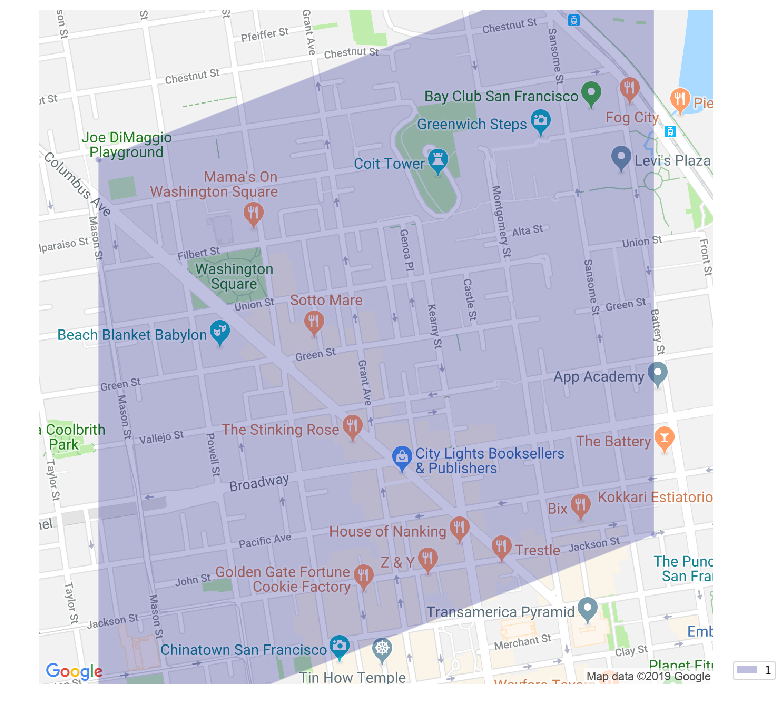

In [45]:
for row in closest_to_times:
    show_cell(row.cell_id)

In [ ]:
def vector_distance_to_cell_fun(x, cell_vector=cell_vector):
    features, centroid = x
    import math
    return math.sqrt(features.squared_distance(cell_vector))